In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

/home/markus/.local/lib/python3.7/site-packages/iotfunctions/bif.py:1899: UserWarning: IoTCalcSettings is deprecated. Use entity type constants instead of a metadata provider to set entity type properties
  warnings.warn(('IoTCalcSettings is deprecated. Use entity type constants'


In [4]:
credentials = {
  "tenantId": "AnalyticsServiceDev",
  "as_api_host": "https://api-dev.connectedproducts.internetofthings.ibmcloud.com",
  "as_api_key": "a-69xgm4-8bdgtvnsv4",
  "as_api_token": "9X_tMKdupOiJ!mzaPV",
  "db2": {
    "username": "bluadmin",
    "password": "ZmM5MmE5NmZkZGZl",
    "databaseName": "BLUDB",
    "port": 50000,
    "httpsUrl": "https://dashdb-enterprise-yp-dal13-74.services.dal.bluemix.net:50000",
    "host": "dashdb-enterprise-yp-dal13-74.services.dal.bluemix.net"
  }
}

In [5]:
db_schema = None
db = Database(credentials=credentials)

/home/markus/.local/lib/python3.7/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [16]:
table = db.get_table("MARKUS_TEST_ROBOT1")
start_ts = dt.datetime.utcnow() - dt.timedelta(days=30)
end_ts = dt.datetime.utcnow()
df = db.read_table(table, None, None, None, "evt_timestamp", start_ts, end_ts)
print (table)

MARKUS_TEST_ROBOT1
   deviceid              evt_timestamp          devicetype  \
0     73002 2019-08-04 07:56:27.937717  Markus_Test_Robot1   
1     73002 2019-08-04 08:01:27.937717  Markus_Test_Robot1   
2     73000 2019-08-04 08:06:27.937717  Markus_Test_Robot1   
3     73000 2019-08-04 08:11:27.937717  Markus_Test_Robot1   
4     73001 2019-08-04 08:16:27.937717  Markus_Test_Robot1   
5     73002 2019-08-04 08:21:27.937717  Markus_Test_Robot1   
6     73000 2019-08-04 08:26:27.937717  Markus_Test_Robot1   
7     73000 2019-08-04 08:31:27.937717  Markus_Test_Robot1   
8     73002 2019-08-04 08:36:27.937717  Markus_Test_Robot1   
9     73001 2019-08-04 08:41:27.937717  Markus_Test_Robot1   
10    73001 2019-08-04 08:46:27.937717  Markus_Test_Robot1   
11    73001 2019-08-04 08:51:27.937717  Markus_Test_Robot1   
12    73001 2019-08-04 08:56:27.937717  Markus_Test_Robot1   
13    73001 2019-08-04 09:01:27.937717  Markus_Test_Robot1   
14    73004 2019-08-04 09:06:27.937717  Markus_Test

In [17]:
df.describe()

,torque,tool_type,load,speed,travel_time,acc
count,13529.000000,13529.000000,13529.000000,13529.000000,13529.000000,13529.000000
mean,12.170833,821.646907,375.169210,3.164703,1.161366,0.149387
std,1.006591,94.688634,0.997718,1.012049,1.014149,1.009683
min,8.742864,691.000000,371.113476,-1.077383,-2.608801,-4.525116
25%,11.484700,691.000000,374.493197,2.479620,0.473556,-0.543640
50%,12.167004,803.000000,375.168736,3.171420,1.153287,0.146672
75%,12.857487,909.000000,375.840389,3.856291,1.848906,0.840048
max,15.813299,909.000000,379.385668,6.896967,6.762974,3.831663


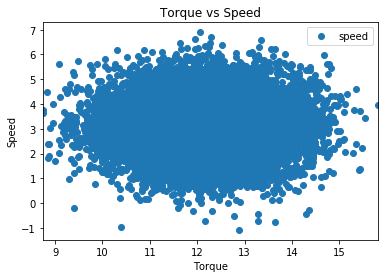

In [24]:
dfsub = df[['torque','speed']]
dfsub.plot(x='torque', y='speed', style='o')  
plt.title('Torque vs Speed')  
plt.xlabel('Torque')  
plt.ylabel('Speed')  
plt.show()

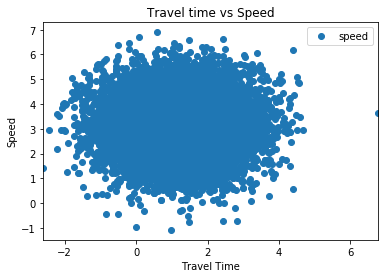

In [25]:
dfsub = df[['travel_time','speed']]
dfsub.plot(x='travel_time', y='speed', style='o')  
plt.title('Travel time vs Speed')  
plt.xlabel('Travel Time')  
plt.ylabel('Speed')  
plt.show()

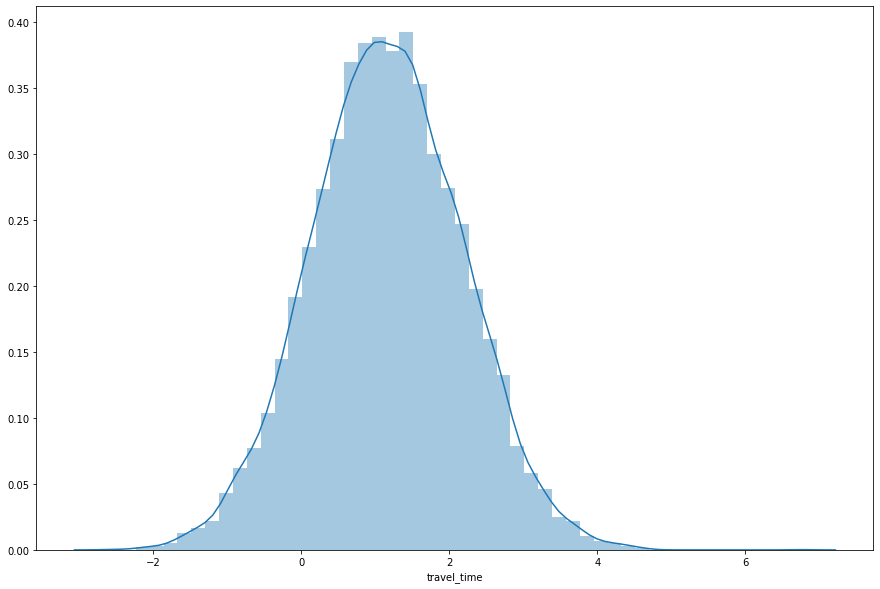

In [26]:
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(dfsub['travel_time'])